In [31]:
from lib.ekyn import *
from torch.utils.data import DataLoader,ConcatDataset,TensorDataset
from lib.datasets import EpochedDataset
from sklearn.model_selection import train_test_split
import torch
from lib.models import RegNetX
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import nn
from torch.nn.functional import relu

def get_loss(model,dataloader,criterion,device):
    model.to(device)
    criterion.to(device)
    with torch.no_grad():
        total = 0
        for Xi,yi in tqdm(dataloader,leave=False):
            Xi,yi = Xi.to(device),yi.to(device)
            logits = model(Xi)
            loss = criterion(logits,yi)
            total += loss.item()
    return total/len(dataloader)
CONFIG = {
    'BATCH_SIZE':1024,
    'WINDOW_SIZE':5000,
    'LEARNING_RATE':3e-1,
    'TEST_SIZE':.25,
    'DEVICE':'cuda',
    'DEPTHI':[1],
    'WIDTHI':[4]
}

train_idx,test_idx = train_test_split(get_ekyn_ids()[:4],test_size=.25,random_state=0)
print(train_idx,test_idx)
trainloader = DataLoader(ConcatDataset([EpochedDataset(idx=idx,condition=condition) for idx in train_idx for condition in ['Vehicle','PF']]),batch_size=512,shuffle=True)
devloader = DataLoader(ConcatDataset([EpochedDataset(idx=idx,condition=condition) for idx in test_idx for condition in ['Vehicle','PF']]),batch_size=512,shuffle=True)

['B1-0', 'A1-1', 'A1-0'] ['A4-0']


In [83]:
class RegNetY(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.c1 = nn.Conv1d(in_channels=1,out_channels=16,kernel_size=101,stride=2,padding=101//2,bias=False)
        self.gap = nn.AvgPool1d(kernel_size=2500)
        self.fc1 = nn.Linear(in_features=16,out_features=3)
    def forward(self,x):
        embedding = self.c1(x)
        x = relu(embedding)
        x = self.gap(x).squeeze()
        x = self.fc1(x)
        return x
model = RegNetY()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(),lr=CONFIG['LEARNING_RATE'])
model.to(CONFIG['DEVICE']);

In [89]:
lossi = []
for Xi,yi in tqdm(trainloader):
    Xi,yi = Xi.to(CONFIG['DEVICE']),yi.to(CONFIG['DEVICE'])
    logits = model(Xi)
    loss = criterion(logits,yi)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    lossi.append(loss.item())

100%|██████████| 102/102 [00:01<00:00, 90.07it/s]


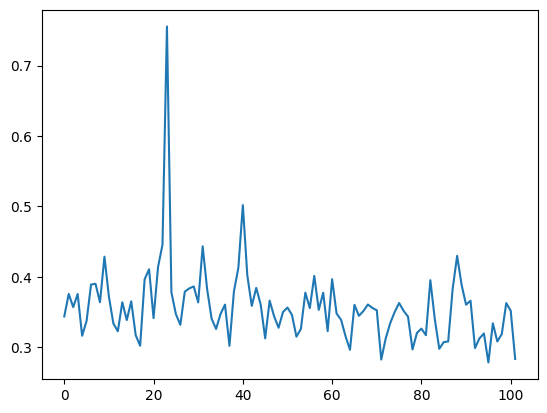

In [90]:
plt.plot(lossi)

In [91]:
from lib.utils import evaluate
evaluate(devloader,model,criterion,CONFIG['DEVICE'])

100%|██████████| 34/34 [00:00<00:00, 129.34it/s]


(1.3565844262347502,
 {'precision': 0.6477325706127602,
  'recall': 0.5581113355511554,
  'f1': 0.5625680682161297},
 tensor([1., 2., 1.,  ..., 1., 1., 1.]),
 tensor([1., 2., 1.,  ..., 1., 1., 1.]),
 tensor([[5.0956e-08, 9.9064e-01, 9.3619e-03],
         [5.0139e-06, 7.3019e-02, 9.2698e-01],
         [1.6957e-09, 9.9937e-01, 6.3214e-04],
         ...,
         [2.8962e-06, 9.9798e-01, 2.0201e-03],
         [2.8170e-06, 9.9420e-01, 5.7971e-03],
         [8.7814e-06, 9.8014e-01, 1.9855e-02]]))